In [26]:
import datajoint as dj
import pandas as pd
from datetime import date
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

# Establish connection 
dj.config['database.host'] = '34.82.94.188'
dj.config['database.user'] = 'yonib'
dj.config['database.password'] = 'yonib'
dj.conn()

# configure a schema for testing stuff
schema  = dj.schema('yonib_test',locals())

In [2]:
# Set up a stupid schema, just to test out some basic stuff.
@schema
class StupidSimple(dj.Manual):
    definition="""
    x:float
    ---
    y:float
    """

@schema
class SquareX(dj.Imported):
    definition="""
    -> StupidSimple
    ---
    z:float
    """
    
    def _make_tuples(self,key):
        key['z'] = key['x']**2
        self.insert1(key)
        
@schema
class CubeY(dj.Computed):
    definition = """
    ->StupidSimple
    ---
    z:float
    """
    
    def _make_tuples(self,key):
        y = (StupidSimple()&key).fetch1('y')
        key['z'] = y**3
        self.insert1(key)
        

#dj.ERD(schema)
        

In [3]:
# Populate
stupid_simple = StupidSimple()
stupid_simple.insert(({'x':1,'y':.1},{'x':2,'y':.2},{'x':3,'y':.3}),skip_duplicates = True)
stupid_simple

x,y
1.0,0.1
2.0,0.2
3.0,0.3


In [4]:
# compute using keys only
square_x = SquareX()
square_x.populate()
square_x

x,z
1.0,1.0
2.0,4.0
3.0,9.0


In [5]:
# Compute using values
cube_y = CubeY()
cube_y.populate()
cube_y

x,z
1.0,0.001
2.0,0.008
3.0,0.027


In [6]:
# Interestingly, if we update data in upstream we are NOT protected in downstream computations. 
# Because these computations have already run, they will remain fixed.
stupid_simple.update1({'x':1,'y':.001})
cube_y.populate()
cube_y

x,z
1.0,0.001
2.0,0.008
3.0,0.027


In [7]:
# Instead, we need to delete and restore downstream entries
cube_y.delete({'x':1})
cube_y.populate()
cube_y

Deleting 3 rows from `yonib_test`.`__cube_y`
Commit deletes? [yes, No]: yes
Deletes committed.


x,z
1.0,1e-09
2.0,0.008
3.0,0.027


In [8]:
# Here, deleting the parent changes all downstream items
StupidSimple().drop()


`yonib_test`.`stupid_simple` (3 tuples)
`yonib_test`.`__cube_y` (3 tuples)
`yonib_test`.`_square_x` (3 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


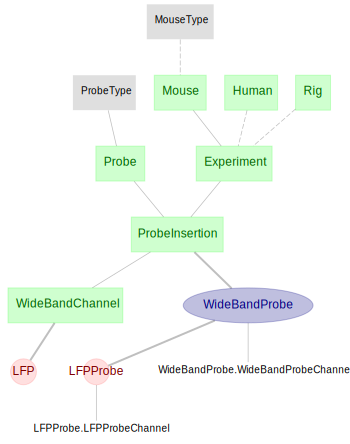

In [24]:
# Define table classes
@schema
class Human(dj.Manual):
    definition = """
    # People involved in project
    userid: varchar(32)    # unique user ID (typically initials)
    ----
    fullname: varchar(255) # first last name
    email: varchar(255) # email for inquiries
    isactive = 1 : bool # do they still work here?
    """

@schema 
class MouseType(dj.Lookup):
    definition = """
    mouse_type: varchar(32) # What type of mouse is it?
    """
    contents =  zip(['Chocolate',
                    'Vanilla',
                    'Strawberry Rhubarb',
                    'Fig Newton'])
    
@schema
class Mouse(dj.Manual):
    definition = """
    # mouse information
    mouse_id: bigint  # unique mouse ID
    ---
    dob: date   # mouse birthday
    sex: enum('M','F','U')    # sex of mouse - male, female, unknown
    -> MouseType
    """

@schema
class Rig(dj.Manual):
    definition = """
    rig_id: int # unique rig identifier
    ---
    rig_name = ''    : varchar(255)     # What to people actually call this rig
    room_num : int     # where does the rig live?
    """
    
    
@schema
class Experiment(dj.Manual):
    definition = """
    # experimental session
    -> Mouse
    date: date # date of the session
    ---
    -> Human
    -> Rig
    """

@schema
class ProbeType(dj.Lookup):
    definition = """
    probe_type:varchar(32) # probe type
    """

    contents =  zip(['tetrode',
                    'neuropixels 1.0',
                    'neuropixels 2.0',
                    'fancy probe'])

@schema
class Probe(dj.Manual):
    definition = """
    -> ProbeType
    probe_serial_number: bigint # Unique probe identifier

"""
@schema
class ProbeInsertion(dj.Manual):
    definition = """
    -> Experiment
    -> Probe
    """
    
@schema         
class WideBandChannel(dj.Manual): # Should really be imported, but won't work with fake data
    definition = """
    -> ProbeInsertion
    channel_number:int

    ---
    wb_sampling_rate: float # sampling rate in Hz
    wide_band_ts:longblob
    wide_band:longblob
    """

@schema 
class LFP(dj.Computed):
    definition = """
    -> WideBandChannel
    ---
    lfp_sampling_rate: float # rate in Hz
    lfp_ts:longblob
    lfp:longblob
    """
    
    
    def make(self,key):
        wb_data = (WideBandChannel()&key).fetch1()
        
        # Bad math; downsampling by more than 13 is not recomended. 
        # Wouldn't do this for real, but since the data isn't real there is no reason for this to be.
        key['lfp_sampling_rate'] = 1000
        ratio = int(wb_data['wb_sampling_rate']/key['lfp_sampling_rate'])
        key['lfp_ts'] = np.arange(wb_data['wide_band_ts'][0],wb_data['wide_band_ts'][-1],ratio)
        key['lfp'] = signal.decimate(wb_data['wide_band'],ratio)
        self.insert1(key)

# This is a fix to a datajoint bug. Plotting this diagram is needed for 
dj.ERD(schema)

In [10]:
# Add some humans to our directory
human = Human()
human_data = ({'userid':'YB',
              'fullname':'Yoni Browning',
              'email':'yoni.browning@alleninstitute.org'},
              {'userid':'JS',
              'fullname':'Josh Siegle',
              'email':'joshs@alleninstitute.org'},
             {'userid':'FQ',
             'fullname':'Frank Quithisjob',
             'email':'frank.quit@alleninstitute.org'})
              
human.insert(human_data,skip_duplicates = True)

In [11]:
# Frank quit his job. Can we change his status?
human.update1({'userid':'FQ','isactive':0})
# output data to table. Yoni wants to be first
H = human.fetch(order_by = 'userid desc',format = 'frame')
H

,fullname,email,isactive
userid,,,
YB,Yoni Browning,yoni.browning@alleninstitute.org,1
JS,Josh Siegle,joshs@alleninstitute.org,1
FQ,Frank Quithisjob,frank.quit@alleninstitute.org,0


In [12]:
# populate the tables with some extra data
# mice 
mouse = Mouse()
mouse_date = ({'mouse_id':12345,
             'dob':date(2021,1,19),
             'sex':'M',
              'mouse_type':'Chocolate'},
            {'mouse_id':78910,
              'dob':date(2021,8,21),
              'sex':'F',
              'mouse_type':'Vanilla'},
            {'mouse_id':11111,
              'dob':date(2021,9,22),
              'sex':'F',
              'mouse_type':'Chocolate'},
            {'mouse_id':22222,
              'dob':date(2021,7,12),
              'sex':'M',
              'mouse_type':'Strawberry Rhubarb'})
mouse.insert(mouse_date,skip_duplicates = True)


# rigs
rig = Rig()
rig.insert(({'rig_id':1,
              'rig_name':'Debug Rig',
              'room_num':320},
           {'rig_id':2,
              'rig_name':'Super Cool Rig',
              'room_num':320}),skip_duplicates = True)

# Probe
probe = Probe()
probe.insert(({'probe_type':'fancy probe',
               'probe_serial_number':1234567},
              {'probe_type':'neuropixels 1.0',
               'probe_serial_number':2345678}),skip_duplicates = True)

# Experiment
experiment = Experiment()
experiment.insert(({'mouse_id':12345,
                    'date':date(2022,1,19),
                    'userid':'YB',
                    'rig_id':1},
                  {'mouse_id':78910,
                    'date':date(2022,1,17),
                    'userid':'YB',
                    'rig_id':1}),skip_duplicates = True)

# Probe Insertion
probe_insertion = ProbeInsertion()
probe_insertion.insert1({'mouse_id':12345,
                        'date':date(2022,1,19),
                        'probe_type':'fancy probe',
                        'probe_serial_number':1234567},skip_duplicates = True)

probe_insertion.insert1({'mouse_id':12345,
                        'date':date(2022,1,19),
                        'probe_type':'neuropixels 1.0',
                        'probe_serial_number':2345678},skip_duplicates = True)

# Add some wide band data.
fs = 32000
for ii in range(0,16):
    channel = ii+1
    ts = np.arange(0,fs*10)
    wb = np.random.randn(fs*10)

    wide_band_channel = WideBandChannel()

    wide_band_channel.insert1({'mouse_id':12345,
                              'date':date(2022,1,19),
                              'probe_type':'fancy probe',
                              'probe_serial_number':1234567,
                              'wb_sampling_rate':fs,
                              'channel_number':channel,
                              'wide_band_ts':ts,
                              'wide_band':wb},skip_duplicates = True)


In [13]:
# THE LFP data will populate based on the wide band data.
# Here, there is one column of wide band for each 
lfp = LFP()
lfp.populate()
lfp

mouse_id unique mouse ID,date date of the session,probe_type probe type,probe_serial_number Unique probe identifier,channel_number,lfp_sampling_rate rate in Hz,lfp_ts,lfp
12345,2022-01-19,fancy probe,1234567,1,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,2,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,3,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,4,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,5,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,6,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,7,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,8,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,9,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,fancy probe,1234567,10,1000.0,=BLOB=,=BLOB=


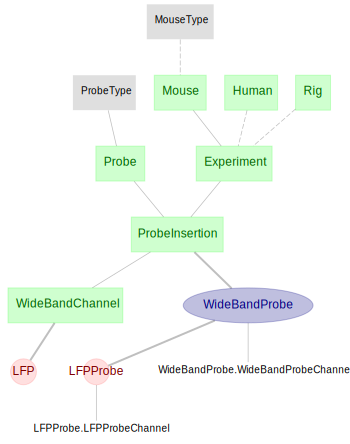

In [20]:
# Now that I have the basics, we can try building a nested and replicating the behavior above.
@schema
class WideBandProbe(dj.Imported): # Should really be imported, but won't work with fake data
    definition="""
    ->ProbeInsertion
    """
    
    class WideBandProbeChannel(dj.Part):
        definition = """
        ->master
        channel_number:int
            ---
        wb_sampling_rate: float # sampling rate in Hz
        wide_band_ts:longblob
        wide_band:longblob
        """
    # Because we don't have real data, wide band probe will autopopulate with fake data
    def make(self,key):
        self.insert1(key)
        for ii in range(0,16):
            key['wb_sampling_rate'] = 32000
            key['channel_number'] = ii+1
            key['wide_band'] = np.random.randn(key['wb_sampling_rate']*10)
            key['wide_band_ts'] = np.arange(0,fs*10)
            WideBandProbe.WideBandProbeChannel.insert1(key)

            

@schema
class LFPProbe(dj.Computed): # Should really be imported, but won't work with fake data
    definition="""
    ->WideBandProbe
    """
    
    class LFPProbeChannel(dj.Part):
        definition = """
        ->master
        channel_number:int
        ---
        lfp_sampling_rate: float # rate in Hz
        lfp_ts:longblob
        lfp:longblob
        """
    # Because we don't have real data, wide band probe will autopopulate with fake data
    def make(self,key):
        self.insert1(key)
        
        wb_data_set = WideBandProbe.WideBandProbeChannel.fetch()
        for ii in range(0,len(wb_data_set)): 
            wb_data = wb_data_set[ii]
            # Bad math; downsampling by more than 13 is not recomended. 
            # Wouldn't do this for real, but since the data isn't real there is no reason for this to be.

            key['lfp_sampling_rate'] = 1000
            ratio = int(wb_data['wb_sampling_rate']/key['lfp_sampling_rate'])
            key['lfp_ts'] = np.arange(wb_data['wide_band_ts'][0],wb_data['wide_band_ts'][-1],ratio)
            key['lfp'] = signal.decimate(wb_data['wide_band'],ratio)
            key['channel_number'] = wb_data_set[ii]['channel_number']
            LFPProbe.LFPProbeChannel.insert1(key,skip_duplicates = True)

dj.ERD(schema)


In [15]:
# Add some wide band data.
# This is a little funky because the data are fake and look the same...
wide_band_probe = WideBandProbe()
wide_band_probe.populate()
wide_band_probe.WideBandProbeChannel()&'probe_type = "neuropixels 1.0"'

mouse_id unique mouse ID,date date of the session,probe_type probe type,probe_serial_number Unique probe identifier,channel_number,wb_sampling_rate sampling rate in Hz,wide_band_ts,wide_band
12345,2022-01-19,neuropixels 1.0,2345678,1,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,2,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,3,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,4,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,5,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,6,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,7,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,8,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,9,32000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,10,32000.0,=BLOB=,=BLOB=


In [23]:
# Now do the same computation as before, this time using the nested structure
LFPProbe().populate()
LFPProbe().LFPProbeChannel()&'probe_type = "neuropixels 1.0"'

mouse_id unique mouse ID,date date of the session,probe_type probe type,probe_serial_number Unique probe identifier,channel_number,lfp_sampling_rate rate in Hz,lfp_ts,lfp
12345,2022-01-19,neuropixels 1.0,2345678,1,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,2,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,3,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,4,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,5,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,6,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,7,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,8,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,9,1000.0,=BLOB=,=BLOB=
12345,2022-01-19,neuropixels 1.0,2345678,10,1000.0,=BLOB=,=BLOB=


In [29]:
@schema 
class Text(dj.Manual):
    definition = """
    x:int
    ---
    y:varchar(255)
    """